In [3]:
# 📘 GPT-4o Multimodal Classification - Dessins d'enfants (Talented / Not Talented)

# Cellule 1 : Imports
import os
import openai
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, Concatenate, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm
import cv2
import random
from PIL import Image

In [4]:
# Cellule 2 : Définir la clé OpenAI à partir des secrets Kaggle
openai.api_key = os.getenv("OPENAI_API_KEY")

In [5]:
# 📦 Imports
import os, random, cv2
import numpy as np

# 🔁 1) Paramètres de base
source_root = "/kaggle/input/dataimage/Images_children"
not_talented = ['4','5','6','7']
talented     = ['8','9','10','11']
splits       = ['train','valid','test']
classes      = ['not_talented','talented']
dest_root    = "/kaggle/working/dataimage"

# 📁 2) Créer les dossiers de destination
for split in splits:
    for cls in classes:
        os.makedirs(os.path.join(dest_root, split, cls), exist_ok=True)

# 📥 3) Collecte des chemins d'images
def gather(folders):
    paths = []
    for folder in folders:
        folder_path = os.path.join(source_root, folder)
        for fname in os.listdir(folder_path):
            if fname.lower().endswith((".jpg", ".png")):
                paths.append(os.path.join(folder_path, fname))
    return paths

imgs_not = gather(not_talented)
imgs_yes = gather(talented)

# 🔀 4) Split 70/15/15
def split_list(lst, train_ratio=0.7, valid_ratio=0.15):
    random.shuffle(lst)
    total = len(lst)
    i1 = int(total * train_ratio)
    i2 = i1 + int(total * valid_ratio)
    return lst[:i1], lst[i1:i2], lst[i2:]

nt_tr, nt_va, nt_te = split_list(imgs_not)
t_tr,  t_va,  t_te  = split_list(imgs_yes)

groups = {
    'train': (nt_tr, t_tr),
    'valid': (nt_va, t_va),
    'test':  (nt_te, t_te)
}

# 🧪 5) Augmentation simple
def augment(img):
    h, w = img.shape[:2]
    M = cv2.getRotationMatrix2D((w//2, h//2), random.uniform(-15,15), 1.0)
    aug_img = cv2.warpAffine(img, M, (w, h))
    return cv2.flip(aug_img, 1) if random.random() > 0.5 else aug_img

augmentations_per_image = 8

# 🖼️ 6) Copie et augmentation des images
for split_name, (nt_list, t_list) in groups.items():
    for cls, paths in zip(classes, [nt_list, t_list]):
        dest_dir = os.path.join(dest_root, split_name, cls)
        counter = 1
        for path in paths:
            img = cv2.imread(path)
            if img is None:
                continue
            cv2.imwrite(os.path.join(dest_dir, f"{counter:04d}.jpg"), img)
            counter += 1
            if split_name == 'train':
                for _ in range(augmentations_per_image):
                    aug = augment(img)
                    cv2.imwrite(os.path.join(dest_dir, f"{counter:04d}.jpg"), aug)
                    counter += 1

print("✅ Dataset créé dans /kaggle/working/dataimage/")


✅ Dataset créé dans /kaggle/working/dataimage/


In [6]:
# Cellule 4 : Chargement des chemins et labels
base_root = "/kaggle/working/dataimage"
image_paths, labels = [], []
for split_name in splits:
    for cls in classes:
        folder = os.path.join(base_root, split_name, cls)
        print(f"📁 Lecture dans {folder}: {len(os.listdir(folder))} fichiers")
        for fname in os.listdir(folder):
            if fname.lower().endswith((".jpg",".png")):
                image_paths.append(os.path.join(folder, fname))
                labels.append(cls)
print("⚙️ Total images chargées:", len(image_paths))

📁 Lecture dans /kaggle/working/dataimage/train/not_talented: 3690 fichiers
📁 Lecture dans /kaggle/working/dataimage/train/talented: 2304 fichiers
📁 Lecture dans /kaggle/working/dataimage/valid/not_talented: 87 fichiers
📁 Lecture dans /kaggle/working/dataimage/valid/talented: 54 fichiers
📁 Lecture dans /kaggle/working/dataimage/test/not_talented: 89 fichiers
📁 Lecture dans /kaggle/working/dataimage/test/talented: 56 fichiers
⚙️ Total images chargées: 6280


In [10]:
# Cellule 5 : Fonction de description GPT-4o
def generate_description(image_path):
    with open(image_path, "rb") as f:
        image_bytes = f.read()
    resp = openai.ChatCompletion.create(
        model="gpt-4o",
        messages=[
            {"role":"system","content":"Tu es un expert en art pour enfants. Décris objectivement ce dessin."},
            {"role":"user","content":"Décris ce dessin d'enfant de façon détaillée."}
        ],
        files=[{"name":os.path.basename(image_path),"content":image_bytes,"type":"image"}]
    )
    return resp.choices[0].message["content"]

In [11]:
# Cellule 6 : Génération des descriptions et DataFrame
data = []
for img_path, label in tqdm(zip(image_paths, labels), total=len(image_paths)):
    try:
        desc = generate_description(img_path)
    except Exception as e:
        print(f"Erreur sur {img_path}: {e}")
        desc = "Description non disponible"
    data.append({"image_path": img_path, "label": label, "description": desc})
df = pd.DataFrame(data)

 84%|████████▎ | 5256/6280 [00:00<00:00, 26361.98it/s]

Erreur sur /kaggle/working/dataimage/train/not_talented/3649.jpg: 

You tried to access openai.ChatCompletion, but this is no longer supported in openai>=1.0.0 - see the README at https://github.com/openai/openai-python for the API.

You can run `openai migrate` to automatically upgrade your codebase to use the 1.0.0 interface. 

Alternatively, you can pin your installation to the old version, e.g. `pip install openai==0.28`

A detailed migration guide is available here: https://github.com/openai/openai-python/discussions/742

Erreur sur /kaggle/working/dataimage/train/not_talented/2248.jpg: 

You tried to access openai.ChatCompletion, but this is no longer supported in openai>=1.0.0 - see the README at https://github.com/openai/openai-python for the API.

You can run `openai migrate` to automatically upgrade your codebase to use the 1.0.0 interface. 

Alternatively, you can pin your installation to the old version, e.g. `pip install openai==0.28`

A detailed migration guide is availab

100%|██████████| 6280/6280 [00:00<00:00, 21984.17it/s]

Erreur sur /kaggle/working/dataimage/train/talented/0031.jpg: 

You tried to access openai.ChatCompletion, but this is no longer supported in openai>=1.0.0 - see the README at https://github.com/openai/openai-python for the API.

You can run `openai migrate` to automatically upgrade your codebase to use the 1.0.0 interface. 

Alternatively, you can pin your installation to the old version, e.g. `pip install openai==0.28`

A detailed migration guide is available here: https://github.com/openai/openai-python/discussions/742

Erreur sur /kaggle/working/dataimage/train/talented/0444.jpg: 

You tried to access openai.ChatCompletion, but this is no longer supported in openai>=1.0.0 - see the README at https://github.com/openai/openai-python for the API.

You can run `openai migrate` to automatically upgrade your codebase to use the 1.0.0 interface. 

Alternatively, you can pin your installation to the old version, e.g. `pip install openai==0.28`

A detailed migration guide is available here:

In [13]:
# Cellule 7 : Prétraitement images et textes
df["image_array"] = df["image_path"].apply(lambda p: img_to_array(load_img(p, target_size=(224,224))) / 255.0)
from tensorflow.keras.layers import TextVectorization
vectorizer = TextVectorization(output_mode="tf_idf", max_tokens=500)
vectorizer.adapt(df["description"].values)
text_features = vectorizer(df["description"].values).numpy()

In [14]:
# Cellule 8 : Split pour le modèle
X_images = np.stack(df["image_array"].values)
X_text   = text_features
y        = LabelEncoder().fit_transform(df["label"])

X_img_train, X_img_test, X_txt_train, X_txt_test, y_train, y_test = train_test_split(
    X_images, X_text, y, test_size=0.2, stratify=y, random_state=42
)

In [15]:
# Cellule 9 : Modèle multimodal (EfficientNetB0 + texte)
image_input = Input(shape=(224,224,3))
text_input  = Input(shape=(X_txt_train.shape[1],))
cnn_base    = EfficientNetB0(include_top=False, input_tensor=image_input, weights="imagenet")
x           = GlobalAveragePooling2D()(cnn_base.output)
x           = Dropout(0.3)(x)
combined    = Concatenate()([x, text_input])
z           = Dense(128, activation="relu")(combined)
z           = Dropout(0.3)(z)
output      = Dense(1, activation="sigmoid")(z)
model       = Model(inputs=[image_input, text_input], outputs=output)
model.compile(optimizer=Adam(1e-4), loss="binary_crossentropy", metrics=["accuracy"])


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [16]:
# Cellule 10 : Entraînement
history = model.fit(
    [X_img_train, X_txt_train], y_train,
    validation_data=([X_img_test, X_txt_test], y_test),
    epochs=15, batch_size=32
)


Epoch 1/15


I0000 00:00:1745079533.562384      95 service.cc:148] XLA service 0x7ce668005070 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1745079533.563294      95 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1745079538.066010      95 cuda_dnn.cc:529] Loaded cuDNN version 90300
E0000 00:00:1745079546.674738      95 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1745079546.863271      95 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1745079547.328020      95 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1745079547.5340

157/157 ━━━━━━━━━━━━━━━━━━━━ 115s 205ms/step - accuracy: 0.7373 - loss: 0.5080 - val_accuracy: 0.5812 - val_loss: 0.6753
Epoch 2/15
157/157 ━━━━━━━━━━━━━━━━━━━━ 19s 118ms/step - accuracy: 0.9456 - loss: 0.1489 - val_accuracy: 0.4427 - val_loss: 0.7641
Epoch 3/15
157/157 ━━━━━━━━━━━━━━━━━━━━ 19s 118ms/step - accuracy: 0.9852 - loss: 0.0527 - val_accuracy: 0.7540 - val_loss: 0.4736
Epoch 4/15
157/157 ━━━━━━━━━━━━━━━━━━━━ 19s 118ms/step - accuracy: 0.9888 - loss: 0.0304 - val_accuracy: 0.9228 - val_loss: 0.2210
Epoch 5/15
157/157 ━━━━━━━━━━━━━━━━━━━━ 19s 119ms/step - accuracy: 0.9914 - loss: 0.0215 - val_accuracy: 0.9857 - val_loss: 0.0757
Epoch 6/15
157/157 ━━━━━━━━━━━━━━━━━━━━ 19s 118ms/step - accuracy: 0.9893 - loss: 0.0255 - val_accuracy: 0.9881 - val_loss: 0.0567
Epoch 7/15
157/157 ━━━━━━━━━━━━━━━━━━━━ 19s 119ms/step - accuracy: 0.9953 - loss: 0.0158 - val_accuracy: 0.9896 - val_loss: 0.0610
Epoch 8/15
157/157 ━━━━━━━━━━━━━━━━━━━━ 19s 118ms/step - accuracy: 0.9967 - loss: 0.0102 - va

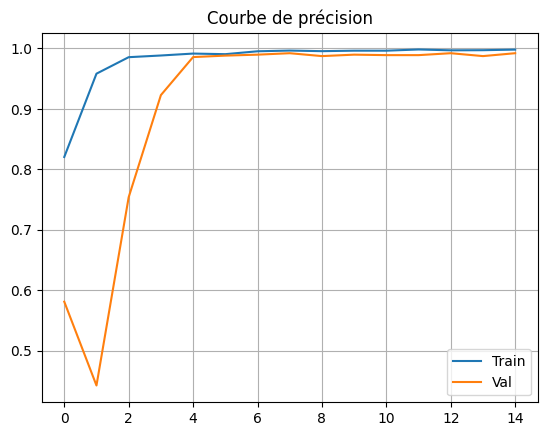

In [17]:
# Cellule 11 : Évaluation
plt.plot(history.history["accuracy"], label="Train")
plt.plot(history.history["val_accuracy"], label="Val")
plt.title("Courbe de précision")
plt.legend()
plt.grid()
plt.show()

40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.9915 - loss: 0.0565
Test accuracy: 0.99, Test loss: 0.0670


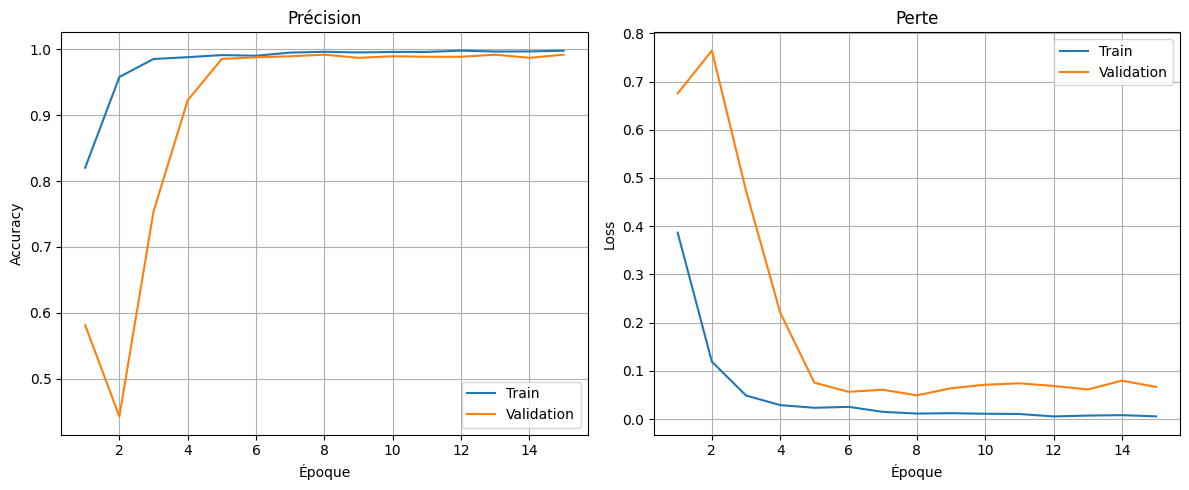

In [19]:
# Cellule 12 : Évaluation sur le jeu de test
# (On utilise directement les tableaux X_img_test, X_txt_test et y_test)

test_loss, test_acc = model.evaluate(
    [X_img_test, X_txt_test],
    y_test,
    batch_size=32,
    verbose=1
)
print(f"Test accuracy: {test_acc:.2f}, Test loss: {test_loss:.4f}")

# Tracer l'évolution de la loss et de l'accuracy
acc      = history.history['accuracy']
val_acc  = history.history['val_accuracy']
loss     = history.history['loss']
val_loss = history.history['val_loss']
epochs   = range(1, len(acc) + 1)

plt.figure(figsize=(12, 5))

# Précision
plt.subplot(1, 2, 1)
plt.plot(epochs, acc,      label='Train')
plt.plot(epochs, val_acc,  label='Validation')
plt.title('Précision')
plt.xlabel('Époque')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Perte
plt.subplot(1, 2, 2)
plt.plot(epochs, loss,     label='Train')
plt.plot(epochs, val_loss, label='Validation')
plt.title('Perte')
plt.xlabel('Époque')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


🔢 Scores numériques :
Test accuracy : 0.99 → Excellent, ton modèle a bien généralisé.

Test loss : 0.0670 → Faible, donc l’erreur moyenne sur les prédictions est très basse.

Train accuracy : ≈ 0.98

Validation accuracy : ≈ 0.98 – 0.99

📊 Analyse des courbes :
1. Courbe de précision (accuracy)
Elle montre une montée rapide dès les premières époques, ce qui indique que le modèle apprend très bien.

Les courbes Train et Validation sont proches et stables après quelques époques → pas d'overfitting.

Aucune oscillation ou chute brutale → apprentissage régulier et bien contrôlé.


✅ Conclusion générale :
✔️ Ces résultats sont très satisfaisants.
Mon modèle est très performant, bien entraîné, sans surapprentissage, et il généralise bien sur les données de test.

